# 불균형 데이터셋 해결하기
- BorderlineSMOTE
    - Borderline-SMOTE는 SMOTE의 변형입니다. 합성 데이터가 두 데이터 사이에 무작위로 생성되는 SMOTE와 달리
    Borderline-SMOTE는 두 클래스 간의 결정 경계를 따라 합성 데이터만 만듭니다.
    - Borderline-SMOTE에는 Borderline-SMOTE1 및 Borderline-SMOTE2 두 종류가 있습니다. 
    - Borderline-SMOTE1은 다수의 데이터가 결정 경계에서 오 분류를 일으키는 다수의 클래스를 오버 샘플링
    - Borderline-SMOTE2는 소수 클래스만 오버 샘플링
    - Borderline-SMOTE는 경계 결정 근처에서 오 분류가 자주 발생한다는 것을 알고있을 때 가장 잘 사용됩니다. <br>
    (참고) 오버 샘플링은 다수 클래스 비율에 따라 소수 클래스 비율을 리샘플링하는 것이다.<br>
    (참고) SMOTE는 k- 최근 접 이웃 알고리즘을 사용하여 합성 데이터를 생성한다.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
from imblearn.over_sampling import BorderlineSMOTE
import numpy as np
import random

In [ ]:
# 하이퍼 파라미터
EPOCHS = 100

## 모델 정의

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(1024, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x, training=False, mask=None):
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)

## 데이터셋 준비(불균형한 데이터셋)

In [ ]:
cifar10 = tf.keras.datasets.cifar10 # 32x32x3

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# TODO: 학습 데이터를 Imbalanced small dataset으로 변형하기
x_train_small = list()
y_train_small = list()
for x, y in zip(x_train, y_train):
    if (y == 0 and random.randint(0, 100) < 10) or y == 1:
        x_train_small.append(x[:])
        y_train_small.append(y)

x_test_small = list()
y_test_small = list()
for x, y in zip(x_test, y_test):
    if y == 0 or y == 1:
        x_test_small.append(x[:])
        y_test_small.append(y)

x_train = np.stack(x_train_small, axis=0)
y_train = np.stack(y_train_small, axis=0)

x_test = np.stack(x_test_small, axis=0)
y_test = np.stack(y_test_small, axis=0)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32).prefetch(2048)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).prefetch(2048)
# tf.data.Dataset.from_tensor_slices 함수는 tf.data.Dataset 를 생성하는 함수로 입력된 텐서로부터 slices를 생성
# shuffle( )은 입력된 buffer_size만큼 data를 채우고 무작위로 sampling하여 새로운 data로 바꿈
# 완벽한 셔플링을 위해서는 데이터 세트의 전체 크기보다 크거나 같은 버퍼 크기가 필요
# prefetch(): 훈련 속도를 더 빠르게
# prefetch(1)을 호출하면 데이터셋은 항상 한 배치가 미리 준비되도록 함

170508288/170498071 [==============================] - 2s 0us/step


## Keras API 모델 학습 (불균형한 데이터셋)

In [ ]:
model = MyModel()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)

Epoch 1/100
174/174 [==============================] - 3s 10ms/step - loss: 0.3770 - accuracy: 0.8932 - precision: 0.9158 - recall: 0.9708 - val_loss: 0.6234 - val_accuracy: 0.6760 - val_precision: 0.6117 - val_recall: 0.9640
Epoch 2/100
174/174 [==============================] - 1s 8ms/step - loss: 0.2693 - accuracy: 0.9062 - precision: 0.9209 - recall: 0.9802 - val_loss: 0.6025 - val_accuracy: 0.7040 - val_precision: 0.6339 - val_recall: 0.9660
Epoch 3/100
174/174 [==============================] - 1s 8ms/step - loss: 0.2430 - accuracy: 0.9150 - precision: 0.9283 - recall: 0.9816 - val_loss: 0.8939 - val_accuracy: 0.6030 - val_precision: 0.5582 - val_recall: 0.9880
Epoch 4/100
174/174 [==============================] - 1s 8ms/step - loss: 0.2380 - accuracy: 0.9130 - precision: 0.9282 - recall: 0.9794 - val_loss: 0.8632 - val_accuracy: 0.6200 - val_precision: 0.5690 - val_recall: 0.9890
Epoch 5/100
174/174 [==============================] - 1s 8ms/step - loss: 0.2179 - accuracy: 0.923

## 불균형 데이터셋 학습과정 그리기

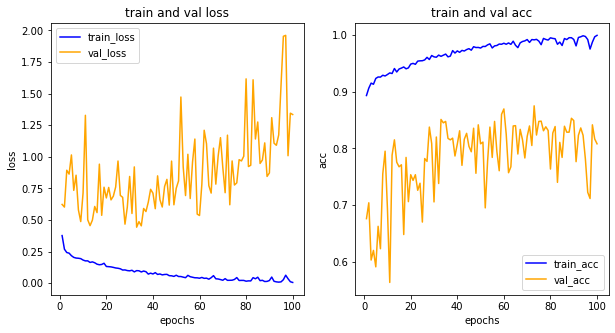

In [ ]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['accuracy']
val_acc = his_dict['val_accuracy']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

## 데이터셋 준비 (BorderlineSMOTE)

In [ ]:
# TODO: BorderlineSMOTE 적용하기
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3])).astype(np.float32)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3])).astype(np.float32)

smote = BorderlineSMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32).prefetch(2048)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).prefetch(2048)

## Keras API 모델 학습 (BorderlineSMOTE)

In [ ]:
model = MyModel()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)

Epoch 1/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6196 - accuracy: 0.7420 - precision: 0.7526 - recall: 0.7210 - val_loss: 0.5256 - val_accuracy: 0.7490 - val_precision: 0.8866 - val_recall: 0.5710
Epoch 2/100
313/313 [==============================] - 2s 8ms/step - loss: 0.4232 - accuracy: 0.8148 - precision: 0.8353 - recall: 0.7842 - val_loss: 0.5490 - val_accuracy: 0.7390 - val_precision: 0.6755 - val_recall: 0.9200
Epoch 3/100
313/313 [==============================] - 2s 7ms/step - loss: 0.3637 - accuracy: 0.8515 - precision: 0.8758 - recall: 0.8192 - val_loss: 0.4826 - val_accuracy: 0.7820 - val_precision: 0.8895 - val_recall: 0.6440
Epoch 4/100
313/313 [==============================] - 2s 8ms/step - loss: 0.3020 - accuracy: 0.8858 - precision: 0.9143 - recall: 0.8514 - val_loss: 0.4960 - val_accuracy: 0.7830 - val_precision: 0.8685 - val_recall: 0.6670
Epoch 5/100
313/313 [==============================] - 2s 8ms/step - loss: 0.2550 - accuracy: 0.9026

## 균형 데이터셋 학습과정 그리기

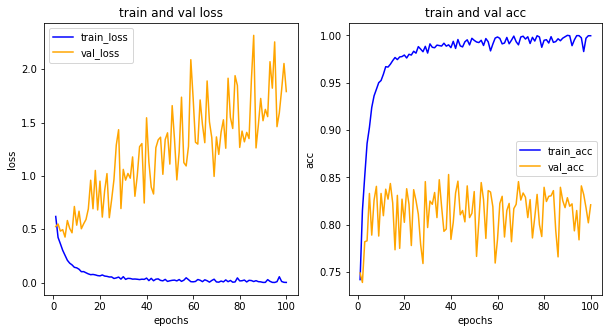

In [ ]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['accuracy']
val_acc = his_dict['val_accuracy']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()